Definitions

Recency - days since last customer transaction

Frequency - number of transactions in the last 12 months

Monetary Value - total spend in the last 12 months

## Data Preparation

In [195]:
#import librarys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [196]:
#import Dataset
retail = pd.read_excel('Online Retail.xlsx')

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Pre-Processing Data

In [197]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Duplicated Value

In [198]:
retail.duplicated().sum()

5268

In [199]:
total_data = len(retail)
total_duplicates = retail.duplicated().sum()
percentage_duplicates = (total_duplicates / total_data) * 100
percentage_duplicates

0.9721189350979592

In [200]:
retail = retail.drop_duplicates()
retail.duplicated().sum()

0

### Missing Value

In [201]:
retail.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [202]:
missing_percentage = retail.isna().mean() * 100
missing_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.270945
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.163377
Country         0.000000
dtype: float64

In [203]:
# Isi nilai yang hilang dengan 'Unknown' atau ID unik lainnya
retail['CustomerID'].fillna('Unknown', inplace=True)
retail['Description'].fillna('Unknown', inplace=True)

retail.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Dataset Check

In [204]:
retail.describe()

,Quantity,UnitPrice
count,536641.000000,536641.000000
mean,9.620029,4.632656
std,219.130156,97.233118
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [205]:
# Filter data di mana Quantity < 0
filtered_df = retail[retail['Quantity'] < 0]

# Hitung jumlah baris yang memenuhi kriteria
jumlah = filtered_df.shape[0]
total = retail.shape[0]
persentase = (jumlah / total) * 100

print("Quantity < 0:", jumlah)
print("% Quantity < 0 :", persentase, "%")

Quantity < 0: 10587
% Quantity < 0 : 1.9728272718633126 %


In [206]:
# Filter data di mana UnitPrice < 0
filtered_df = retail[retail['UnitPrice'] < 0]

# Hitung jumlah baris yang memenuhi kriteria
jumlah = filtered_df.shape[0]
total = retail.shape[0]
persentase = (jumlah / total) * 100

print("UnitPrice < 0:", jumlah)
print("% UnitPrice < 0 :", persentase, "%")


UnitPrice < 0: 2
% UnitPrice < 0 : 0.00037268863169232316 %


In [207]:
# Filter data untuk memilih baris di mana Quantity > 0 dan UnitPrice > 0
retail_df = retail[(retail['Quantity'] > 0) & (retail['UnitPrice'] > 0)]

# Menampilkan deskripsi statistik dari DataFrame yang telah difilter
retail_df.describe()

,Quantity,UnitPrice
count,524878.000000,524878.000000
mean,10.616600,3.922573
std,156.280031,36.093028
min,1.000000,0.001000
25%,1.000000,1.250000
50%,4.000000,2.080000
75%,11.000000,4.130000
max,80995.000000,13541.330000


## RFM Segmentation

### RFM Metrics

In [208]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [209]:
retail_df['TotalSum'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_13644\4262707614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df['TotalSum'] = retail_df['Quantity'] * retail_df['UnitPrice']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [210]:
print('Min:{}; Max:{}'.format(min(retail_df.InvoiceDate),
max(retail_df.InvoiceDate)))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:50:00


In [211]:
snapshot_date = max(retail_df.InvoiceDate) + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [212]:
# Aggregate data on a customer level
datamart = retail_df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})
# Rename columns for easier interpretation
datamart.rename(columns = {'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'MonetaryValue'}, inplace=True)
# Check the first rows
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


### RFM Segments

In [213]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartiles.values)
datamart

,Recency,Frequency,MonetaryValue,R
CustomerID,,,,
12346.0,326,1,77183.60,1
12347.0,2,182,4310.00,4
12348.0,75,31,1797.24,2
12349.0,19,73,1757.55,3
12350.0,310,17,334.40,1
...,...,...,...,...
18281.0,181,7,80.82,1
18282.0,8,12,178.05,4
18283.0,4,721,2045.53,4


In [214]:
f_labels = range(1,5)
m_labels = range(1,5)
f_quartiles = pd.qcut(datamart['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
datamart = datamart.assign(F = f_quartiles.values)
datamart = datamart.assign(M = m_quartiles.values)
datamart

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,4
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2
...,...,...,...,...,...,...
18281.0,181,7,80.82,1,1,1
18282.0,8,12,178.05,4,1,1
18283.0,4,721,2045.53,4,4,4


In [215]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
datamart

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,1.01.04.0,6
12347.0,2,182,4310.00,4,4,4,4.04.04.0,12
12348.0,75,31,1797.24,2,2,4,2.02.04.0,8
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10
12350.0,310,17,334.40,1,1,2,1.01.02.0,4
...,...,...,...,...,...,...,...,...
18281.0,181,7,80.82,1,1,1,1.01.01.0,3
18282.0,8,12,178.05,4,1,1,4.01.01.0,6
18283.0,4,721,2045.53,4,4,4,4.04.04.0,12


### Analyzing RFM Segments

In [216]:
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
4.04.04.0    450
1.01.01.0    381
3.04.04.0    217
1.02.02.0    206
2.01.01.0    179
2.03.03.0    168
3.03.03.0    164
2.02.02.0    158
4.03.03.0    149
3.02.02.0    132
dtype: int64

In [217]:
datamart.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           260.7       8.2         157.4   381
4           177.2      13.6         240.0   388
5           152.9      21.2         366.6   518
6            96.0      27.9         820.5   458
7            79.5      38.0         758.3   462
8            64.1      56.0         987.3   454
9            45.9      78.7        1795.1   414
10           32.4     110.5        2056.4   426
11           21.3     187.2        4055.8   388
12            7.2     661.0       13182.0   450

In [218]:
def segment_me(df):
    if df['RFM_Score'] >= 9:
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Silver'
    else:
        return 'Bronze'

datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            218.6      10.9         199.1   769
Gold               26.4     268.0        5437.9  1678
Silver             99.9      35.3         721.1  1892

## Data Processing

### Manage Skewness

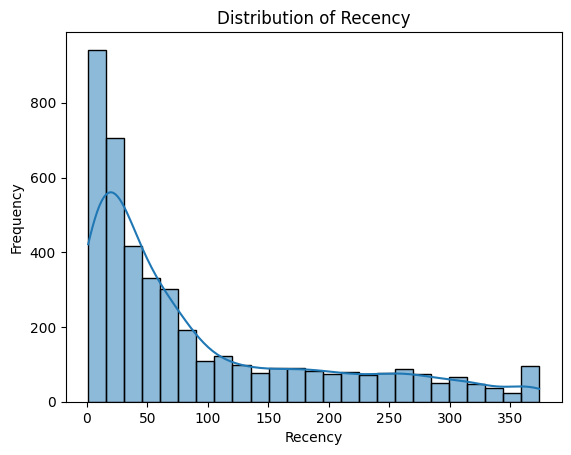

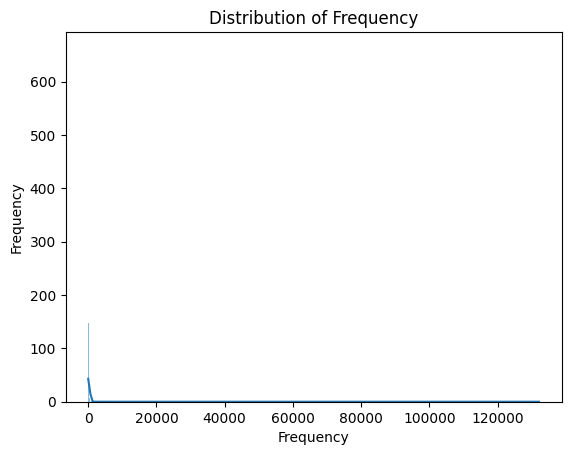

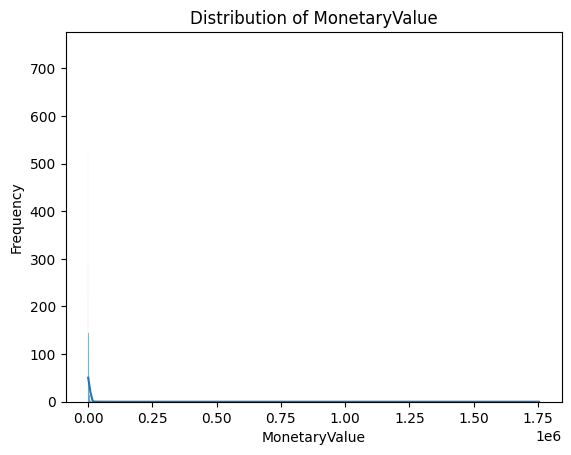

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt

# Daftar kolom yang akan ditampilkan histplot-nya
columns = ['Recency', 'Frequency', 'MonetaryValue']

# Mengulang setiap kolom dalam daftar
for column in columns:
    sns.histplot(datamart[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


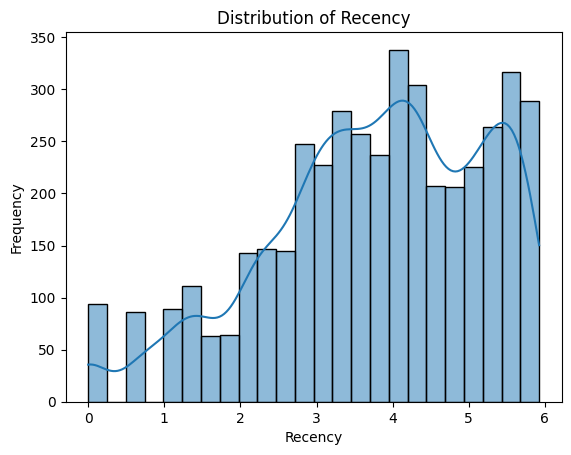

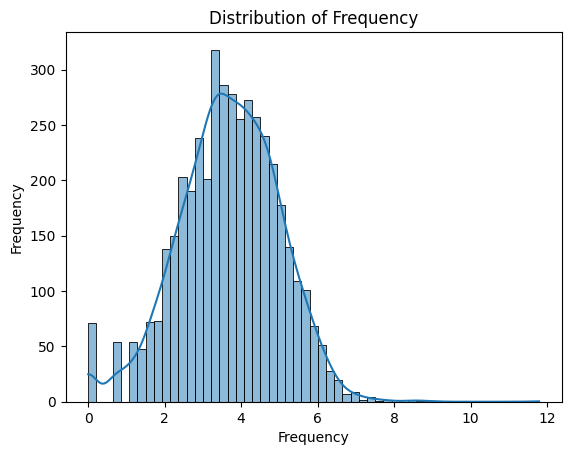

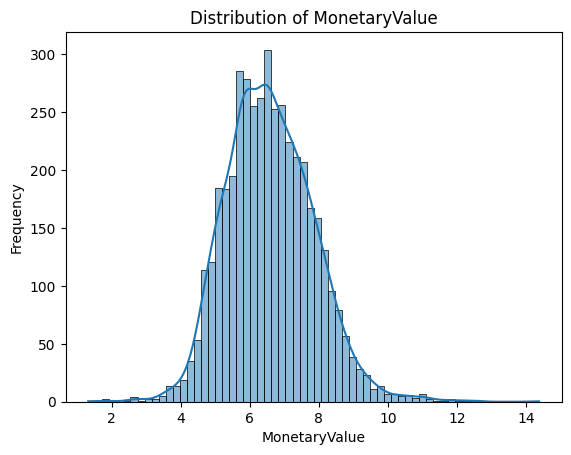

In [220]:
# Daftar kolom yang akan ditransformasi
columns = ['Recency', 'Frequency', 'MonetaryValue']
    
for column in columns:
    column_log = np.log(datamart[column])
    sns.histplot(column_log, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

### Centering & Scalling Variable

In [221]:
datamart.reset_index().head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
0,12346.0,326,1,77183.60,1,1,4,1.01.04.0,6,Silver
1,12347.0,2,182,4310.00,4,4,4,4.04.04.0,12,Gold
2,12348.0,75,31,1797.24,2,2,4,2.02.04.0,8,Silver
3,12349.0,19,73,1757.55,3,3,4,3.03.04.0,10,Gold
4,12350.0,310,17,334.40,1,1,2,1.01.02.0,4,Bronze


In [222]:
datamart_rfm = pd.DataFrame(datamart.reset_index())
datamart_rfm = datamart_rfm[['Recency','Frequency','MonetaryValue']]
datamart_rfm.head()

,Recency,Frequency,MonetaryValue
0,326,1,77183.60
1,2,182,4310.00
2,75,31,1797.24
3,19,73,1757.55
4,310,17,334.40


In [223]:
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4339.000000,4339.000000,4.339000e+03
mean,92.515326,120.967504,2.452664e+03
std,100.012295,2018.000172,2.808606e+04
min,1.000000,1.000000,3.750000e+00
25%,18.000000,17.000000,3.065050e+02
50%,51.000000,41.000000,6.685800e+02
75%,142.000000,98.000000,1.660890e+03
max,374.000000,132186.000000,1.754902e+06


In [224]:
datamart_centered = datamart_rfm - datamart_rfm.mean()
datamart_centered.describe().round(2)

,Recency,Frequency,MonetaryValue
count,4339.00,4339.00,4339.00
mean,0.00,0.00,-0.00
std,100.01,2018.00,28086.06
min,-91.52,-119.97,-2448.91
25%,-74.52,-103.97,-2146.16
50%,-41.52,-79.97,-1784.08
75%,49.48,-22.97,-791.77
max,281.48,132065.03,1752449.25


In [225]:
datamart_scaled = datamart_rfm / datamart_rfm.std()
datamart_scaled.describe().round(2)

,Recency,Frequency,MonetaryValue
count,4339.00,4339.00,4339.00
mean,0.93,0.06,0.09
std,1.00,1.00,1.00
min,0.01,0.00,0.00
25%,0.18,0.01,0.01
50%,0.51,0.02,0.02
75%,1.42,0.05,0.06
max,3.74,65.50,62.48


In [226]:
scaler = StandardScaler()
scaler.fit(datamart_rfm)
datamart_normalized = scaler.transform(datamart_rfm) 
print('mean: ', datamart_normalized.mean(axis=0).round(2))
print('std: ', datamart_normalized.std(axis=0).round(2))

mean:  [0. 0. 0.]
std:  [1. 1. 1.]


## Sequence of structuring preprocessing steps

In [227]:
# Unskew the data
datamart_log = np.log(datamart_rfm)

In [228]:
# Normalize the variables
scaler = StandardScaler()
scaler.fit(datamart_log)

StandardScaler()

In [229]:
# Store for clustering
datamart_normalized = scaler.transform(datamart_log)

## K-Means Clustering

### Running K-Means

In [230]:
# Initialize KMeans
kmeans = KMeans(n_clusters=2, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Analyzing average RFM values of each cluster

In [231]:
# Create a cluster label column in the original DataFrame
datamart_rfm_k2 = datamart_rfm.assign(Cluster = cluster_labels)

In [232]:
# Calculate average RFM values and size for each cluster
datamart_rfm_k2.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         141.0      25.0         476.0  2437
1          30.0     244.0        4985.0  1902

## Choosing Number of Clusters

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

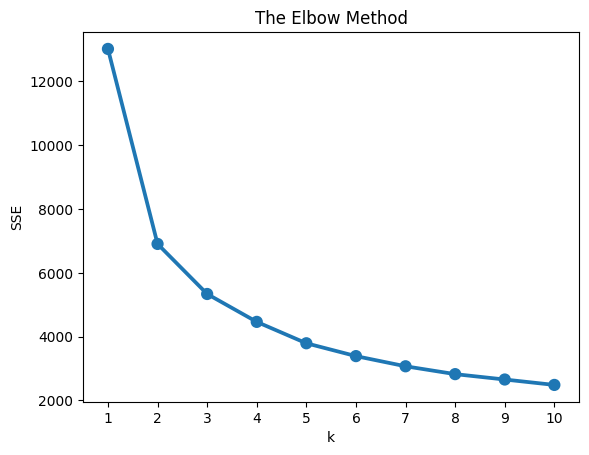

In [233]:
# Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Experimental approach - analyze segments

- Build clustering at and around elbow solution
- Analyze their properties - average RFM values
- Compare against each other and choose one which makes most business sense

In [234]:
# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels3 = kmeans.labels_

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [235]:
# Create a cluster label column in the original DataFrame
datamart_rfm_k3 = datamart_rfm.assign(Cluster = cluster_labels3)

In [236]:
# Calculate average RFM values and size for each cluster
datamart_rfm_k3.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          13.0     402.0        8466.0   944
1          68.0      66.0        1181.0  1862
2         171.0      15.0         294.0  1533

### Profile and interpret segments

- Summary statistics for each cluster e.g. average RFM values
- Snake plots (from market research)
- Relative importance of cluster attributes compared to population

In [237]:
datamart_rfm_k2 = datamart_rfm.assign(Cluster = cluster_labels)

In [238]:
datamart_rfm_k2.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         141.0      25.0         476.0  2437
1          30.0     244.0        4985.0  1902

In [240]:
datamart_rfm_k3 = datamart_rfm.assign(Cluster = cluster_labels3)

In [241]:
datamart_rfm_k3.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          13.0     402.0        8466.0   944
1          68.0      66.0        1181.0  1862
2         171.0      15.0         294.0  1533

### Snake plots to understand and compare segments

- Market research technique to compare different segments
- Visual representation of each segment's attributes
- Need to first normalize data (center & scale)
- Plot each cluster's average normalized values of each attribute

### Prepare data for a snake plot

In [242]:
datamart_normalized = pd.DataFrame(datamart_normalized,
    index=datamart_rfm.index,
    columns=datamart_rfm.columns)
datamart_normalized['Cluster'] = datamart_rfm_k3['Cluster']

In [245]:
datamart_melt = pd.melt(datamart_normalized.reset_index(),
    id_vars=['Cluster'],
    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
    var_name='Attribute',
    value_name='Value')

<Axes: title={'center': 'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

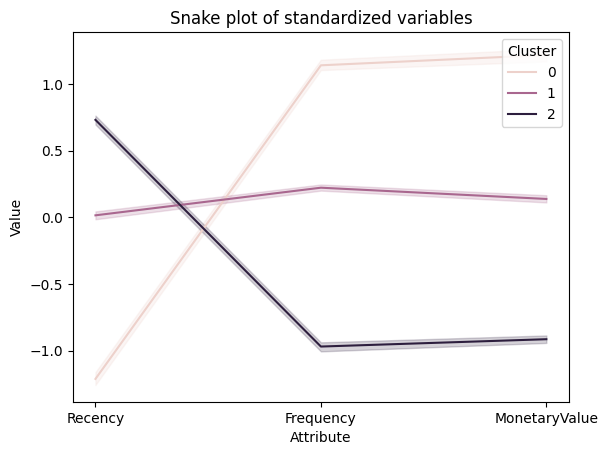

In [246]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=datamart_melt)

### Useful technique to identify relative importance of each segment's attribute

- Calculate average values of each cluster
- Calculate average values of population
- Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when
- cluster average equals population average)

In [247]:
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean()
population_avg = datamart_rfm.mean()
relative_imp = cluster_avg / population_avg - 1

### Analyze and plot relative importance

- As a ratio moves away from 0, attribute importance for a segment (relative to total pop.) increases.

In [248]:
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.86,2.32,2.45
1,-0.26,-0.46,-0.52
2,0.85,-0.88,-0.88


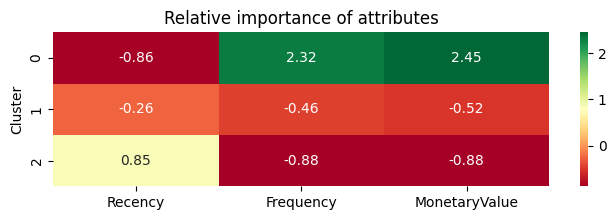

In [249]:
# Plot heatmap
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()